In [2]:
from config import init_polish_perplexity_model, init_english_perplexity_model
from tqdm import tqdm
from analysis.nlp_transformations import separate_previous_conversation, remove_footers
from typing import List
from models.email import EmailGeneratedInDB
from dao.email import DAOEmailGenerated, DAORealEmail
import matplotlib.pyplot as plt

from dao.attribute import DAOAttribute
from models.attribute import Attribute
from models.base_mongo_model import MongoObjectId
from analysis.nlp_transformations import replace_links_with_text

dao_attribute: DAOAttribute = DAOAttribute()

In [6]:
init_polish_perplexity_model()
init_english_perplexity_model()

In [7]:
from analysis.attribute_retriving import calculate_perplexity
text = """Dzień dobry,

Czy jest już znana dokladna data rozdania nagród?

Z wyrazami szacunku,
Paweł Gryka"""
perplexity = calculate_perplexity(text, 'pl')
print(perplexity)

1.679492712020874


In [12]:

dao_generated_emails: DAOEmailGenerated = DAOEmailGenerated()
dao_real_emails: DAORealEmail = DAORealEmail()
already_calculated = dao_attribute.find_all()
already_calculated_ids = [attr.referenced_doc_id for attr in already_calculated]
generated_emails: List[EmailGeneratedInDB] = dao_generated_emails.find_many_by_query({'_id': {'$nin': already_calculated_ids}})

for gen_email in tqdm(generated_emails, total=len(generated_emails), desc=f'Calculating perplexity', unit='emails', miniters=1):
    og_email = dao_real_emails.find_one(gen_email.og_db_name, {'_id': gen_email.og_doc_id})
    gen_perplexity = calculate_perplexity(gen_email.text_plain, gen_email.language, return_base_ppl=True)
    _, og_text = separate_previous_conversation(og_email.text_plain)
    og_text = remove_footers(og_text)
    real_perplexity = calculate_perplexity(og_text, gen_email.language, return_base_ppl=True)
    if gen_perplexity is None or real_perplexity is None:
        continue
    gen_text_without_links = replace_links_with_text(gen_email.text_plain)
    dao_attribute.update_or_create('email_generated_dataset', gen_email.id,
                                   [PerplexityBaseMetric(value=gen_perplexity),
                                    NumberOfWordsMetric(value=len(gen_text_without_links.split())),
                                    NumberOfCharactersMetric(value=len(gen_text_without_links))])
    real_text_without_links = replace_links_with_text(og_text)
    dao_attribute.update_or_create(gen_email.og_db_name, og_email.id,
                                   [PerplexityBaseMetric(value=real_perplexity),
                                    NumberOfWordsMetric(value=len(real_text_without_links.split())),
                                    NumberOfCharactersMetric(value=len(real_text_without_links))])

Calculating perplexity: 100%|██████████| 2050/2050 [13:38:29<00:00, 23.96s/emails]   


In [21]:
def plot_from_file(file_path: str, label: str, num_bin = 10, max_value=5):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Step 2: Convert the data from strings to floats
    data = [float(line.strip()) for line in lines]
    data_concat = []
    for d in data:
        if d<max_value:
            data_concat.append(d)
        else:
            data_concat.append(max_value)

    # Step 3: Create and display the histogram
    plt.hist(data_concat, bins=num_bin)  # You can adjust the number of bins as needed
    plt.title(f'Perplexity of {label} Data')
    plt.xlabel('Perplexity value')
    plt.ylabel('Frequency')
    plt.show()

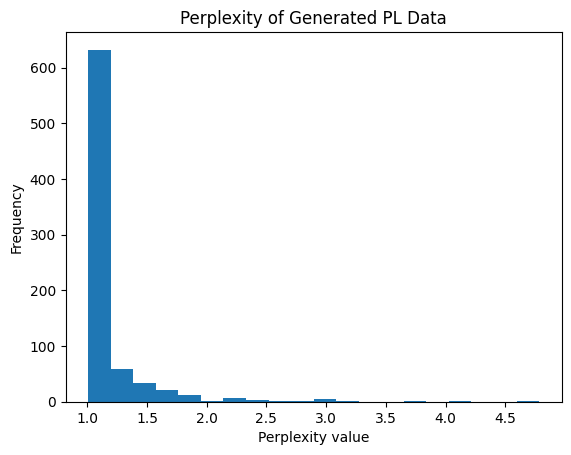

In [24]:
plot_from_file('perplexity_generated_pl.txt', 'Generated PL', 20, 5)

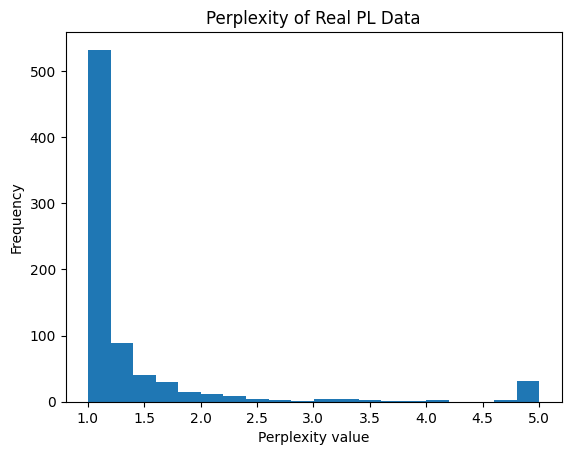

In [25]:
plot_from_file('perplexity_real_pl.txt', 'Real PL', 20, 5)

In [5]:
from models.metric import PerplexityMetric
import math

all_attributes = dao_attribute.find_all()
for attr in tqdm(all_attributes, total=len(all_attributes), desc=f'Calculating perplexity per word', unit='email', miniters=1):
    perplexity_base = None
    denominator = None
    for metric in attr.metrics:
        if isinstance(metric, PerplexityBaseMetric):
            perplexity_base = metric.value
        if isinstance(metric, NumberOfWordsMetric):
            denominator = metric.value
    if perplexity_base is not None and denominator is not None and denominator > 0:
        ppl = math.exp(perplexity_base/denominator)
        dao_attribute.update_or_create(attr.referenced_db_name, attr.referenced_doc_id, [PerplexityMetric(value=ppl)])


Calculating perplexity per word: 100%|██████████| 32724/32724 [14:43<00:00, 37.03email/s]


In [6]:
generated_data = dao_attribute.find_many_by_query({'referenced_db_name': 'email_generated_dataset'})
real_data = dao_attribute.find_many_by_query({'referenced_db_name': {'$ne': 'email_generated_dataset'}})
generated_ppl = [attr.metrics[3].value for attr in generated_data]
real_ppl = [attr.metrics[3].value for attr in real_data]
generated_ppl_few_words = [attr.metrics[3].value for attr in generated_data if attr.metrics[1].value < 100]

real_ppl_few_words = [attr.metrics[3].value for attr in real_data if attr.metrics[1].value < 100]

generated_ppl_many_words = [attr.metrics[3].value for attr in generated_data if attr.metrics[1].value > 100]

real_ppl_many_words = [attr.metrics[3].value for attr in real_data if attr.metrics[1].value > 100]

In [32]:
print(len(real_ppl_few_words))
print(len(generated_ppl_few_words))
print(len(real_ppl_many_words))
print(len(generated_ppl_many_words))

6994
6069
10588
8936


In [28]:
import numpy as np


def hist_perplexity(data, title, num_bin = 10, max_value=5):
    data_to_plot = []
    for d in data:
        if d<max_value:
            data_to_plot.append(d)
        else:
            data_to_plot.append(max_value)

    w = (max_value-1)/num_bin
    plt.hist(data_to_plot, bins=np.arange(1, max_value + w, w))
    plt.title(title)
    plt.xlim([1, max_value])
    plt.xlabel('Perplexity value')
    plt.ylabel('Number of emails')
    plt.show()

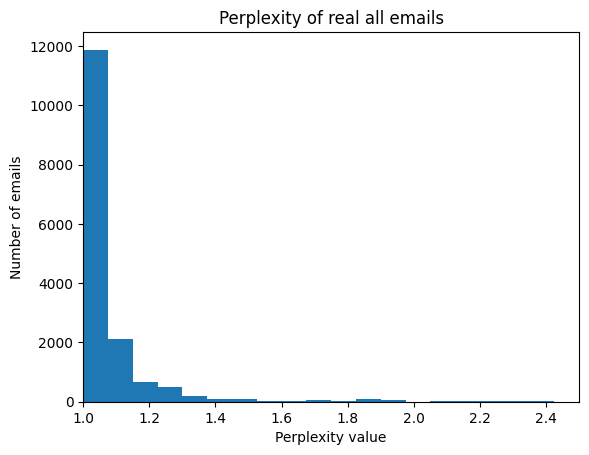

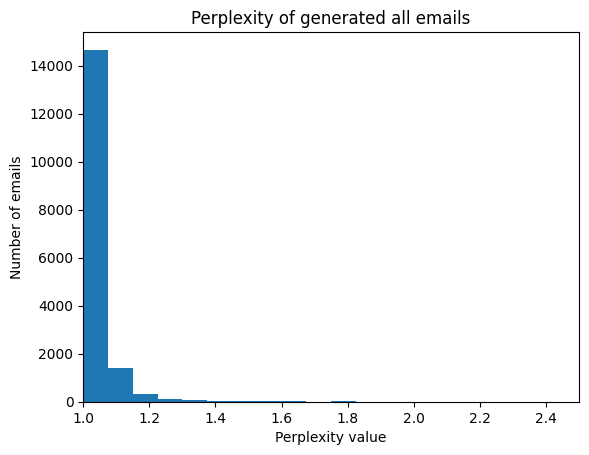

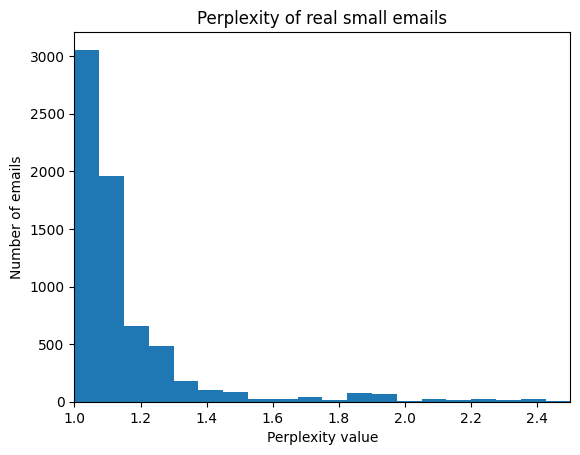

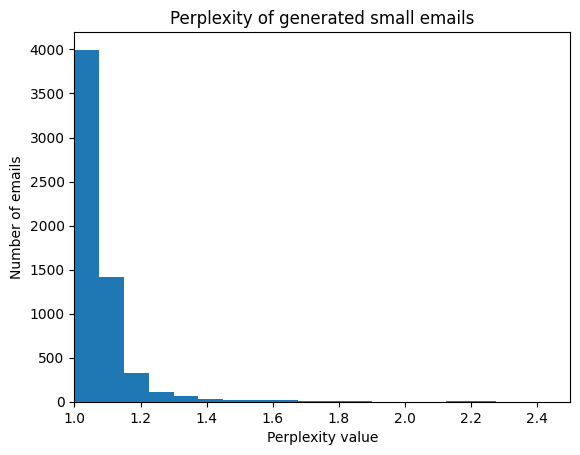

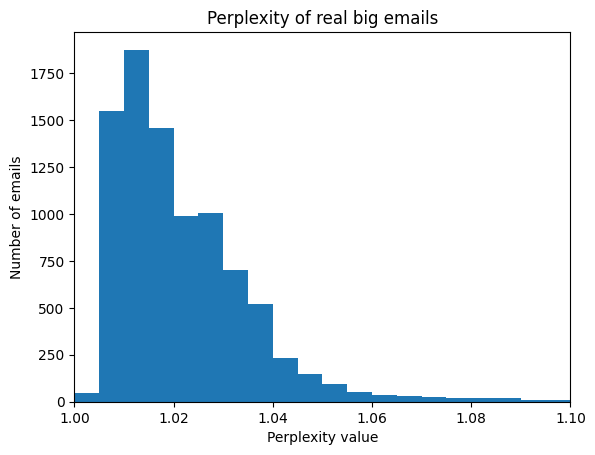

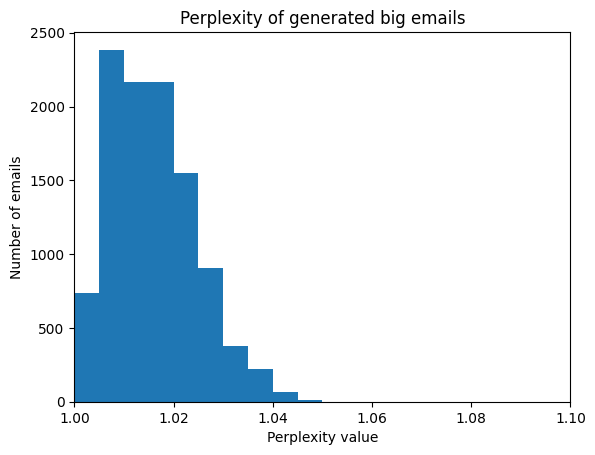

In [33]:
num_of_bins = 20
max_value = 2.5
hist_perplexity(real_ppl, 'Perplexity of real all emails', num_of_bins, max_value)
hist_perplexity(generated_ppl, 'Perplexity of generated all emails', num_of_bins, max_value)

hist_perplexity(real_ppl_few_words, 'Perplexity of real small emails', num_of_bins, max_value)
hist_perplexity(generated_ppl_few_words, 'Perplexity of generated small emails', num_of_bins, max_value)

hist_perplexity(real_ppl_many_words, 'Perplexity of real big emails', num_of_bins, 1.1)
hist_perplexity(generated_ppl_many_words, 'Perplexity of generated big emails', num_of_bins, 1.1)

['to',
 'jest',
 'przykładowyt',
 'teskst.',
 'raz,',
 'dwa,',
 'trzy',
 'cztery',
 'pięc']